In [1]:
from time import time
import pandas as pd
import numpy as np
import itertools
import re
import datetime
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
nltk.download('stopwords')
stopwords = stopwords.words('english')
%load_ext autotime


Using TensorFlow backend.
[nltk_data] Downloading package stopwords to C:\Users\Aashwin
[nltk_data]     Ranjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Getting Data 
TRAIN_CSV = "./train.csv"
TEST_CSV = "./test.csv"
VALIDATE_CSV = "./validataion.csv"
EMBEDDING_FILE = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'


#Loading Data
train_df = pd.read_csv(TRAIN_CSV, error_bad_lines=False)
test_df = pd.read_csv(TEST_CSV, error_bad_lines=False)
validate_df=pd.read_csv(VALIDATE_CSV, error_bad_lines=False)

stops = stopwords

def textList(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


print("Preprocessing is Done!!")

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

title_cols = ['title1_en', 'title2_en']

# Iterate over the questions only of the training test and validation datasets
for dataset in [train_df, test_df,validate_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for title in title_cols:

            t2n = []  
            for word in textList(row[title]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    t2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    t2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index,title, t2n)
            
print("Dataset Traversed!!")
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

print("Cell successfully compiled!")


b'Skipping line 7026: expected 8 fields, saw 9\nSkipping line 44341: expected 8 fields, saw 9\nSkipping line 58784: expected 8 fields, saw 10\n'
b'Skipping line 99101: expected 8 fields, saw 10\nSkipping line 104716: expected 8 fields, saw 9\nSkipping line 127866: expected 8 fields, saw 10\n'
b'Skipping line 140436: expected 8 fields, saw 9\nSkipping line 152888: expected 8 fields, saw 11\n'
b'Skipping line 47254: expected 7 fields, saw 9\n'


Preprocessing is Done!!


C:\Conda\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Dataset Traversed!!
Cell successfully compiled!
time: 8min 3s


In [32]:
max_seq_length = min(train_df.title1_en.map(lambda x: len(x)).max(),
                     train_df.title2_en.map(lambda x: len(x)).max(),
                     test_df.title1_en.map(lambda x: len(x)).max(),
                     test_df.title2_en.map(lambda x: len(x)).max(),
                     validate_df.title1_en.map(lambda x: len(x)).max(),
                     validate_df.title2_en.map(lambda x: len(x)).max())
    

print("Sequence length calculated!!")
#Preparing training and validation
validation_size = len(validate_df)
training_size = len(train_df)
X_train = train_df[title_cols]
X_validation = validate_df[title_cols]
#train_df.label = pd.factorize(train_df.label)[0]
#validate_df.label = pd.factorize(validate_df.label)[0]
Y_train = train_df['label']
Y_validation = validate_df['label']

print("Data prepared!!")
# Split to dicts
X_train = {'left': X_train.title1_en, 'right': X_train.title2_en}
X_validation = {'left': X_validation.title1_en, 'right': X_validation.title2_en}
X_test = {'left': test_df.title1_en, 'right': test_df.title2_en}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

 

print("Labels converted to numpy!!")
# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

print("Dataset constructed!!")
# Make sure data aligns
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

print("cell successfully compiled!!")
print(Y_train)
print(Y_validation)


Sequence length calculated!!
Data prepared!!
Labels converted to numpy!!
Dataset constructed!!
cell successfully compiled!!
[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 1]
time: 3.96 s


In [44]:
from keras.layers import Input

# Model variables
n_hidden = 50
gradient_clipping_norm = 2
batch_size = 64
n_epoch = 7

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))


left_input = Input(shape=(max_seq_length,), dtype = 'float32' )
right_input = Input(shape=(max_seq_length,), dtype = 'float32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Conda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 192353 samples, validate on 64134 samples
Epoch 1/7
192353/192353 [==============================] - 2174s 11ms/step - loss: 0.2607 - acc: 0.7158 - val_loss: 0.5139 - val_acc: 0.2410
Epoch 2/7
192353/192353 [==============================] - 2172s 11ms/step - loss: 0.2333 - acc: 0.7473 - val_loss: 0.5236 - val_acc: 0.2250
Epoch 3/7
192353/192353 [==============================] - 2162s 11ms/step - loss: 0.2236 - acc: 0.7610 - val_loss: 0.5439 - val_acc: 0.2109
Epoch 4/7
192353/192353 [==============================] - 2232s 12ms/step - loss: 0.2167 - acc: 0.7717 - val_loss: 0.5387 - val_acc: 0.2074
Epoch 5/7
192353/192353 [==============================] - 2168s 11ms/step - loss: 0.2116 - acc: 0.7783 - val_loss: 0.5430 - val_acc: 0.2062
Epoch 6/7
192353/192353 [==============================] - 2224s 12ms/step - loss: 0.2075 - acc: 0.7834 - val_loss: 0.5800 - val_acc: 0.2010
Epoch 7/7
192353/192353 [==============================] - 2417s 13ms/step - loss: 0.2042 - acc: 0.7873

Model Saved!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 500, 300)     12611700    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 50)           70200       embedding_7[0][0]              

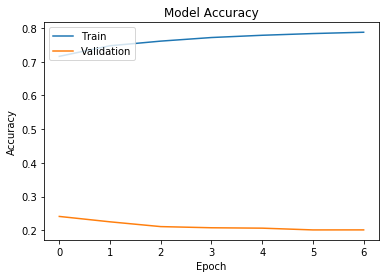

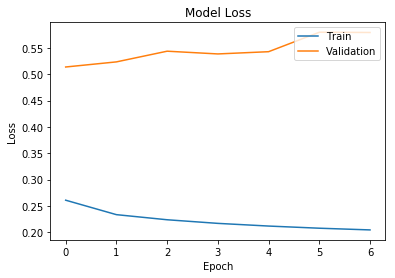

time: 635 ms


In [55]:

from keras.models import load_model
malstm.save('malstm.h5')
print("Model Saved!")
malstm.summary()

print(malstm_trained.history['val_loss'])
print(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()